# Preamble

In [16]:
# dependencies
import numpy as np
import os
import re
import sys
import glob
import collections
import pickle

from scipy.interpolate import interp1d
from scipy import optimize

import pandas as pd
from astropy.io import fits, ascii
import photoz_metrics

from astropy.table import Table, join

import matplotlib
%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns



# options
# %matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc

rc('figure', figsize = (12, 8))
rc('font',**{'size': 30, 'family':'serif', 'serif':['Palatino']})
rc('text', usetex=True)

# plt.style.use('seaborn')
plt.style.use('seaborn-whitegrid')

# sns.set_style('darkgrid')

plt.rc('pdf',fonttype=42)
sns.mpl.rc('figure', figsize = (14, 8))
sns.set_context('notebook', font_scale=2.5, rc={'lines.linewidth': 2.5})



STILTS = 'java -Xmx2048M -jar /Users/coupon/local/bin/stilts.jar'
DATADIR = os.environ['HOME']+'/data/euclid/varTrans'
CURRENTDIR = '../'


# add ./python to python path
path_python = '../python'
if not path_python in sys.path:
    sys.path.insert(0, '../python')

import var_trans_utils as vtu

from importlib import reload

# Simulations



## The reference filter set



u 3679 -0.08 7.36
g 4842 0.21 9.68
r 6439 0.61 12.88
i 7821 0.96 15.64
z 9172 1.29 18.34
vis 7156 0.79 14.31
Y 10862 1.72 21.72
J 13685 2.42 27.37
H 17727 3.43 35.45


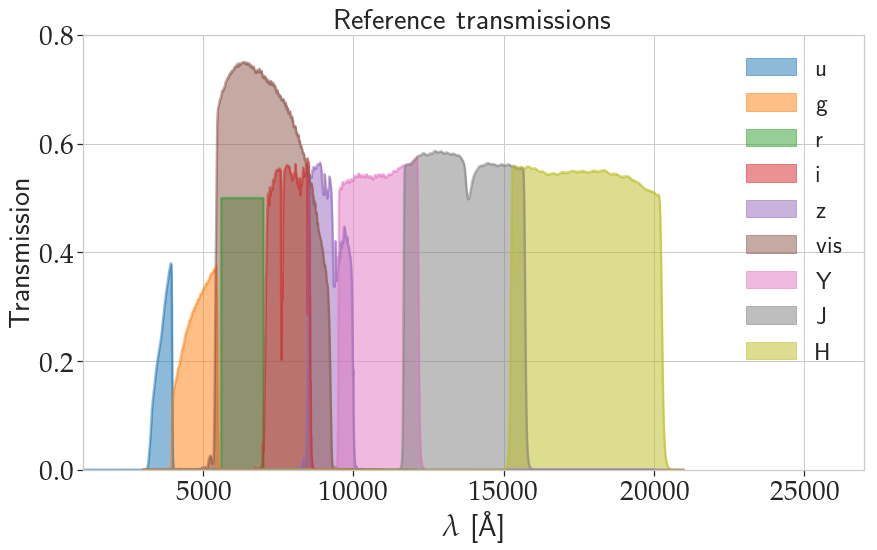

In [17]:
# location of Euclid filters
filter_dir = os.environ['HOME']+'/data/euclid/WP_testing/DC3/filters/final'

# read filter and put in data frames (df)
filter_ref_names = ['u', 'g', 'r', 'i', 'z', 'vis', 'Y', 'J', 'H']
filter_dfs = {}
for f in filter_ref_names:
    filter_dfs[f] = pd.read_csv(
        filter_dir+'/'+f+'.ascii',
        header=0, sep='\s+', 
        names=['lambda', f])

    norm = np.trapz(filter_dfs[f][f], filter_dfs[f]['lambda'])
    mean = np.trapz(
        filter_dfs[f]['lambda']*filter_dfs[f][f], filter_dfs[f]['lambda'])/norm
    z_Blamer = mean/4000.0-1
    print('{} {:.0f} {:.2f} {:.2f}'.format(f, mean, z_Blamer, 0.002*(1+z_Blamer)*4000.))


# replace r filter with top hat
filter_dfs['r'] = pd.DataFrame(vtu.create_r_top_hat_trans('r', top = 0.50))
filter_dfs['r'].rename(columns={'trans': 'r'}, inplace=True)

# plot filters
fig, ax = plt.subplots()
for f in filter_ref_names:
    filter_dfs[f].plot.area(
        x='lambda', stacked=False, 
        title='Reference transmissions', 
        ax=ax,)
    ax.set_xlabel(r'$\lambda$ [\AA{}]')
    ax.set_ylabel('Transmission')

# adjust plot
ax.set_ylim([0.0,0.8])
ax.set_xlim([1000,27000])
plt.legend(loc='upper right', fontsize='small') #, bbox_to_anchor=(1.0, 1.0))

fig.savefig('../plots/reference_filters.pdf')

# write reference filter transmissions
output_dir = CURRENTDIR+'/filters/ref'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for f in filter_ref_names:
    filter_dfs[f].to_csv(output_dir+'/'+f+'.ascii', columns=['lambda', f], 
                 sep=' ', index=False, header=False)   

In [23]:
# recover filter characteristic values
# create and save a nested dictionary
# to save filter characteristics
# VAR = collections.OrderedDict()
# VAR['N'] = VAR_N
# VAR['values'] = VAR_VALUES
# VAR['units'] = VAR_UNITS
with open('../doc/var_filter_char.pickle','rb') as f:
    VAR = pickle.load(f)
VAR_N = VAR['N']
VAR_VALUES = VAR['values'] 
VAR_UNITS = VAR['units']

# get transmission names
filter_var_names = []
for t in VAR_VALUES:
    for i in range(VAR_N):
        filter_var_names.append('r_'+t+str(i))

## The simulated sample



In [24]:
with open(CURRENTDIR+'/filters/filterListAll.ascii', 'w') as file_out: 
    for f in filter_ref_names:
        file_out.write(CURRENTDIR+'/filters/ref/'+f+'.ascii\n')
        
    for f in filter_var_names:
        if 'scaling' in f:
            continue
        dir_name = re.sub(r"[0-9]", '', f).replace('r_', '')
        file_out.write(
            CURRENTDIR+'/filters/'+dir_name+'/'+f+'.ascii\n')

In [25]:
# directory with the reference galaxies' SEDs
ref_dir = os.environ['HOME']+'/data/NNPZ/COSMOS/v2.0/referenceSample'
file_filters = CURRENTDIR+'/filters/filterListAll.ascii'

# output files with all fluxes
file_out = DATADIR+'/fluxes.fits'

# emulate photometry
if False:
    # run shell command to compute photometry
    ! NnpzBuildPhotometry --sample-dir {ref_dir} --filter {file_filters} \
        --out-file {file_out} --out-type F_nu_uJy

    # add scaling
    with fits.open(file_out, hdu=1) as thdu_in:
        cols = []
        for i,v in enumerate(VAR_VALUES['scaling']):
            cols.append(
                fits.Column(
                    name='r_scaling'+str(i),
                    format=thdu_in[1].columns['r'].format, 
                    array=thdu_in[1].data['r']*(1.0+v)))

        thdu_list_out = []
        thdu_list_out.append(thdu_in[0])
        thdu_list_out.append(
            fits.BinTableHDU.from_columns(
                thdu_in[1].columns+fits.ColDefs(cols)))
        for h in thdu_in[2:]:
            thdu_list_out.append(h)

        thdu_out = fits.HDUList(thdu_list_out)
        thdu_out.writeto(file_out.replace(
            '.fits', '_scaling.fits'), overwrite=True)

        thdu_out.close()

In [26]:
# pixel scale in arcsec in COSMOS15 catalogue
PIXEL_SCALE = 0.15

# typical size of Euclid galaxies in arcsec
SIZE_TYPICAL_EUCLID = 0.600770354271

# SIZE_TYPICAL_EUCLID_PIX = SIZE_TYPICAL_EUCLID/PIXEL_SCALE

def match_COSMOS2015(file_in, file_out):
    """ Match file_in with the 'COSMOS15'
    catalogue (Laigle et al. 2016) to get 
    coordinates, size and redshift.
    
    Get and unzip the COSMOS15 catalogue (1.5GB) at
    ftp://ftp.iap.fr/pub/from_users/hjmcc/COSMOS2015/COSMOS2015_Laigle+_v1.1.fits.gz
    
    """

    # read file in
    table_in = Table.read(file_in, hdu=1)

    table_COSMOS15 = Table.read(
        DATADIR+'/COSMOS2015_Laigle+_v1.1.fits', hdu=1)
    #table_COSMOS15 = Table.read(
    #    '/Users/coupon/data/COSMOS/COSMOS2015/COSMOS2015_Laigle+_v1.1_PDF_small.fits', hdu=1)

    # change column name for matching
    table_COSMOS15.rename_column('NUMBER', 'ID')
    
    # change name of redshift as we do simulations
    table_COSMOS15.rename_column('PHOTOZ', 'z_true')

    # convert radius from pixels to arcsec
    table_COSMOS15['radius'] = table_COSMOS15['FLUX_RADIUS']*PIXEL_SCALE
    
    # replace small or unrealistic value with typical Euclid size
    small = table_COSMOS15['radius'] < SIZE_TYPICAL_EUCLID
    table_COSMOS15['radius'][small] = SIZE_TYPICAL_EUCLID
    
    # only keep relevant columns
    table_COSMOS15 = table_COSMOS15[
        'ID', 'ALPHA_J2000', 'DELTA_J2000', 'radius', 'z_true']
    
    # run the matching, keeping all 
    # galaxies in file_in
    table_out = join(
        table_in, table_COSMOS15, 
        join_type='left', keys='ID')
    
    print(table_out)
    
    table_out.write(file_out, overwrite=True)
    
    return

# match_COSMOS2015(DATADIR+'/fluxes_scaling.fits', DATADIR+'/fluxes_COSMOS15.fits')

In [27]:
# INPUT = DATADIR+'/fluxes_COSMOS15.fits'

# depths and sky brightnesses
skies_AB_euclid = {'u': 22.70, 'g': 22.00, 'r': 20.80, 'i': 20.30,
         'z': 19.40, 'vis': 22.33, 'Y': 22.10,
         'J': 22.11, 'H': 22.28}

# 10-sigma depths from J.-C. Cuillandre's report
depths_AB_euclid_wide = {'u': 23.6, 'g': 24.5, 'r': 23.9, 'i': 23.6,
        'z': 23.4, 'vis': 24.6, 'Y': 23.0, 'J': 23.0,
        'H': 23.0}

depths_AB_euclid_deep = {}
for d in depths_AB_euclid_wide:
    depths_AB_euclid_deep[d] = \
        depths_AB_euclid_wide[d]+2.5*np.log10(np.sqrt(40.0))

depths_AB_euclid_calibration = {}
for d in depths_AB_euclid_wide:
    depths_AB_euclid_calibration[d] = \
        depths_AB_euclid_wide[d]+2.5*np.log10(np.sqrt(25.0))

In [28]:
def print_depths(
        filter_ref_names, wide, deep, calibration):
    """ Print depth in table format """

    print('Euclid-survey depths (10 sigmas)\n')
    print('| Filter        | Wide | Calibration | Deep |')
    print('| ------------- |:-------------:|:-------------:|:-------------:|')
    for d in filter_ref_names:
        print('| ${}$ | {:.1f} | {:.1f} | {:.1f} |'.format(
            d, wide[d], calibration[d], deep[d]))

    return

print_depths(
    filter_ref_names,
    depths_AB_euclid_wide,
    depths_AB_euclid_deep,
    depths_AB_euclid_calibration)

Euclid-survey depths (10 sigmas)

| Filter        | Wide | Calibration | Deep |
| ------------- |:-------------:|:-------------:|:-------------:|
| $u$ | 23.6 | 25.3 | 25.6 |
| $g$ | 24.5 | 26.2 | 26.5 |
| $r$ | 23.9 | 25.6 | 25.9 |
| $i$ | 23.6 | 25.3 | 25.6 |
| $z$ | 23.4 | 25.1 | 25.4 |
| $vis$ | 24.6 | 26.3 | 26.6 |
| $Y$ | 23.0 | 24.7 | 25.0 |
| $J$ | 23.0 | 24.7 | 25.0 |
| $H$ | 23.0 | 24.7 | 25.0 |


In [29]:
def get_filter_options(
    depths_AB, skies_AB, filter_names):

    # filter_names = filter_ref_names+filter_var_names
    
    filter_depths_AB=[]
    filter_skies_AB=[]
    for name in filter_names:
        name = name.split('_')[0]
        filter_depths_AB.append(str(depths_AB[name]))
        filter_skies_AB.append(str(skies_AB[name]))

    result = {}
    result['filter_names'] = ','.join(filter_names)
    result['filter_depths_AB'] = ','.join(filter_depths_AB)
    result['filter_skies_AB'] = ','.join(filter_skies_AB)
    result['filter_depths_train_AB'] = ','.join(
        ['{0:.1f}'.format(float(f)+2.5*np.log10(5.0)) for f in filter_depths_AB])
    
    return result

filter_names = filter_ref_names+filter_var_names

filter_options = get_filter_options(
    depths_AB_euclid_wide, skies_AB_euclid, filter_names)

print(filter_options)

{'filter_names': 'u,g,r,i,z,vis,Y,J,H,r_shift0,r_shift1,r_shift2,r_shift3,r_shift4,r_shift5,r_shift6,r_shift7,r_shift8,r_shift9,r_stretch0,r_stretch1,r_stretch2,r_stretch3,r_stretch4,r_stretch5,r_stretch6,r_stretch7,r_stretch8,r_stretch9,r_tilt0,r_tilt1,r_tilt2,r_tilt3,r_tilt4,r_tilt5,r_tilt6,r_tilt7,r_tilt8,r_tilt9,r_softening0,r_softening1,r_softening2,r_softening3,r_softening4,r_softening5,r_softening6,r_softening7,r_softening8,r_softening9,r_scaling0,r_scaling1,r_scaling2,r_scaling3,r_scaling4,r_scaling5,r_scaling6,r_scaling7,r_scaling8,r_scaling9', 'filter_depths_AB': '23.6,24.5,23.9,23.6,23.4,24.6,23.0,23.0,23.0,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9', 'filter_skies_AB': '22.7,22.0,20.8,20.3,19.4,22.33,22.1,22.11,22.28,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8

In [30]:
EXECDIR = 'tmp'
EXECMACHINE = 'isdc'
EXECHOME = '/home/isdc/coupon/'

# EXECMACHINE = 'localhost'
# EXECHOME = '/Users/coupon/'

def configure_cluster(execdir, execmachine):
    """ upload the file and configure the cluster """

    ! ssh {execmachine} "mkdir -p $EXECDIR"
    ! scp ../config/nnpz_base.conf {execmachine}:{execdir}

    return

def replace_in_file(file_name, str_in, str_out):
    """ Replace string inplace in
    file_name.
    """
    
    # read in the file
    with open(file_name, 'r') as file:
        data = file.read()

    # replace the target string
    data = data.replace(str_in, str_out)

    # write the file out again
    with open(file_name, 'w') as file:
        file.write(data)

    return

def submit_job(cmd, job_options=''):
    """ Write a job file and 
    submit it to the cluster """

    file_name = 'submit_job.sh'

    with open(file_name, 'w') as file_out: 
        file_out.write('\
#!/bin/bash \n\
#$ -N compute_pz \n\
#$ -V \n\
#$ -q test \n\
#$ -cwd \n\
#$ -o /home/isdc/coupon/data/tmp/SGE_logs \n\
#$ -e /home/isdc/coupon/data/tmp/SGE_logs \n\
#$ -l h_rt=48:00:00 \n\
#$ -l h_vmem=12G \n\
#$ -l h=!isdc-cn16.astro.unige.ch\n\n\n\
echo $HOSTNAME\n\
date\n\n\n{}\n'.format(cmd))
         
    replace_in_file(file_name, '/Users/coupon/', EXECHOME)

    ! scp {file_name} {EXECMACHINE}:{EXECDIR}
               
    if EXECMACHINE == 'isdc':
        ! ssh {EXECMACHINE} "cd {EXECDIR}; qsub {job_options} {file_name}; exit"

    if EXECMACHINE == 'localhost':
        ! ssh {EXECMACHINE} "cd {EXECDIR}; bash submit_job.sh; exit"

    return

In [33]:
def cmd_simulate(
        file_in, file_out, 
        filter_options, seed=2009182,
        sample = 'all',
        vis_name = 'vis'):
    """ Returns a bash command to 
    simulate a test catalogue """
    
    cmd = ''
    
    if isinstance(seed, str):
        cmd += '{}\n'.format(seed)
    else:
        cmd += 'seed={}\n'.format(seed)

    cmd += 'mkdir -p $( dirname {} ) \n'.format(
        file_out)

    cmd += 'simulate.py -i {} -o {}.tmp -seed $seed \
        -filter_names {} \
        -filter_depths_AB {} \
        -filter_skies_AB {} \
        -r_ref {}\n'.format(
            file_in, file_out,
            filter_options['filter_names'], 
            filter_options['filter_depths_AB'],
            filter_options['filter_skies_AB'],
            SIZE_TYPICAL_EUCLID)
    
    if sample == 'test':
        ra_cut = '(ALPHA_J2000<150.1) && '
    elif sample == 'training':
        ra_cut = '(ALPHA_J2000>=150.1) && '
    elif sample == 'all':
        ra_cut = ''
    else:
        raise Exception('{} sample is not recognised'.format(sample))
       
    cmd += '{0} tpipe {1}.tmp out={1}\
        cmd=\'select \"{2} ({3}_obs_mag < 24.5) \
        && ({3}_obs_mag_err > 0.0)\"\' \n'.format(
            STILTS, file_out, ra_cut, vis_name)
    
    cmd += 'rm -f {}.tmp'.format(file_out)
    
    return cmd

In [34]:
# default filter names
TRAINING_FILTERS =  "[\
(\'u_obs\', \'u_obs_err\'),\
(\'g_obs\', \'g_obs_err\'),\
(\'r_obs\', \'r_obs_err\'),\
(\'i_obs\', \'i_obs_err\'),\
(\'z_obs\', \'z_obs_err\'),\
(\'vis_obs\', \'vis_obs_err\'),\
(\'Y_obs\', \'Y_obs_err\'),\
(\'J_obs\', \'J_obs_err\'),\
(\'H_obs\', \'H_obs_err\')\
]"

TEST_FILTERS =  "[\
(\'u_obs\', \'u_obs_err\'),\
(\'g_obs\', \'g_obs_err\'),\
(\'r_obs\', \'r_obs_err\'),\
(\'i_obs\', \'i_obs_err\'),\
(\'z_obs\', \'z_obs_err\'),\
(\'vis_obs\', \'vis_obs_err\'),\
(\'Y_obs\', \'Y_obs_err\'),\
(\'J_obs\', \'J_obs_err\'),\
(\'H_obs\', \'H_obs_err\')\
]"

def cmd_compute_pz(
        file_test, 
        file_training,
        test_filters=TEST_FILTERS,
        training_filters=TRAINING_FILTERS,
        file_out=None,
    ):
    """compute the photo-z PDFs given a 
    reference (file_training) and a 
    target sample (file_test)
    """

    if file_out is None:
        file_out = file_test.replace('.fits', '_pz.fits')
            
    cmd = 'nnpz nnpz_base.conf \
        --reference_catalog {} \
        --reference_catalog_filters \"{}\" \
        --target_catalog {} \
        --target_catalog_filters \"{}\" \
        --output_file {}\n'.format(
            file_training, 
            training_filters,
            file_test,
            test_filters,
            file_out)
    
    return cmd

In [35]:
def cmd_compute_stats(file_in):
    """compute the photo-z statistics
    """
    
    # to do remove outliers
    
    cmd = 'photoz_metrics.py scatter -i {} -o {}\n'.format(
        file_in, file_in.replace('.fits', '_scatter.pdf'))

    cmd = 'photoz_metrics.py scatter -i {} -o {} \
        -density \n'.format(
        file_in, file_in.replace('.fits', '_density.pdf'))

    cmd += 'photoz_metrics.py PDF -i {} -o {} \
        -stats_output {}\n'.format(
        file_in, file_in.replace('.fits', '_PDF_tomo.pdf'),  
        file_in.replace('.fits', '_PDF_tomo.csv'))

    cmd += 'photoz_metrics.py PDF -i {} -o {} \
        -z_bins 0.55,0.70 -stats_output {}\n'.format(
        file_in, file_in.replace('.fits', '_PDF_z0.63.pdf'),  
        file_in.replace('.fits', '_PDF_z0.63.csv'))

    cmd += 'ls {}; ls {}\n'.format(
        file_in.replace('.fits', '_PDF_tomo.csv'),
        file_in.replace('.fits', '_PDF_z0.63.csv'),
    )
    
    return cmd

In [36]:
# define files
file_input = '{}/fluxes_COSMOS15.fits'.format(DATADIR)
file_training = '{}/fluxes_COSMOS15_East_training_vis24.5.fits'.format(DATADIR)
file_test = '{}/fluxes_COSMOS15_West_test_vis24.5.fits'.format(DATADIR)

# make training catalogue
if False:
    filter_options_training = get_filter_options(
        depths_AB_euclid_calibration, skies_AB_euclid,
        filter_names)
    ! {cmd_simulate( \
        file_input, file_training, \
        filter_options_training, \
        sample='training', seed=20091983)}

# make test catalogue
if False:
    filter_options_test = get_filter_options(
        depths_AB_euclid_wide, skies_AB_euclid,
        filter_names)
    ! {cmd_simulate( \
        file_input, file_test, \
        filter_options_test, \
        sample='test', seed=20091982)}

In [37]:
# run photo-z's locally
if False:
    ! {cmd_compute_pz(file_test, file_training, \
        file_out=file_test.replace('.fits', '_pz_r.fits'))}
    ! {cmd_compute_pz(\
        file_test, file_training, \
        test_filters=TEST_FILTERS.replace('r_', 'r_shift0_'), \
        file_out=file_test.replace('.fits', '_pz_r_shift0.fits'))}
if False:
    !{ cmd_compute_stats(file_test.replace('.fits', '_pz.fits')) }
    !{ cmd_compute_stats(file_test.replace('.fits', '_pz_r_shift0.fits'))}

In [38]:
# run photo-z's on cluster
configure_cluster(EXECDIR, EXECMACHINE)

N_SAMPLES = 20
job_options='-t 1-{}'.format(N_SAMPLES)
seed = 20091982

# transfer files to cluster
if False:
    ! scp {file_input} {file_training} {file_test} isdc:data/euclid/varTrans/
        
# simulate test catalogues
if False:
    filter_options_test = get_filter_options(
        depths_AB_euclid_wide, skies_AB_euclid,
        filter_names)

    print(filter_options_test)
    
    cmd = cmd_simulate( \
        file_input, \
        file_test.replace('.fits','/$( expr $SGE_TASK_ID - 1).fits'), \
        filter_options_test, \
        sample='test', \
        seed='seed=$( expr {} + $SGE_TASK_ID )'.format(seed))
    
    submit_job(cmd, job_options=job_options)
    
# print(filter_to_correct_names)
# compute photo-z's
if False:    
    file_test_batch = file_test.replace('.fits','/$( expr $SGE_TASK_ID - 1).fits')
    for filter_name in filter_var_names+['r']:
        cmd = ''
        cmd += cmd_compute_pz(
                file_test_batch, file_training,
                test_filters=TEST_FILTERS.replace('r_', filter_name+'_'),
                file_out=file_test_batch.replace('.fits', '_pz_'+filter_name+'.fits'))
        cmd += cmd_compute_stats(file_test_batch.replace('.fits', '_pz_'+filter_name+'.fits'))

        submit_job(cmd, job_options=job_options)

# get result back
if False:
    resultdir = file_test.replace('.fits', '')
    ! mkdir -p {resultdir}
    ! scp isdc:{resultdir.replace('/Users', '/home/isdc')}/\*.csv {resultdir}/    
    # ! rsync -avzcup --progress  --include=*.csv isdc:{resultdir}/  ~/{resultdir}/

nnpz_base.conf                                100% 7169     7.0KB/s   00:00    


## Results

### Fixed

/Users/coupon/data/euclid/varTrans/fluxes_COSMOS15_West_test_vis24.5_pz_r.fits
Reading /Users/coupon/data/euclid/varTrans/fluxes_COSMOS15_West_test_vis24.5_pz_r.fits...Done
Applying selection: (data['vis_obs_mag'] < 24.5) & (data['vis_obs_mag_err'] > 0.0)


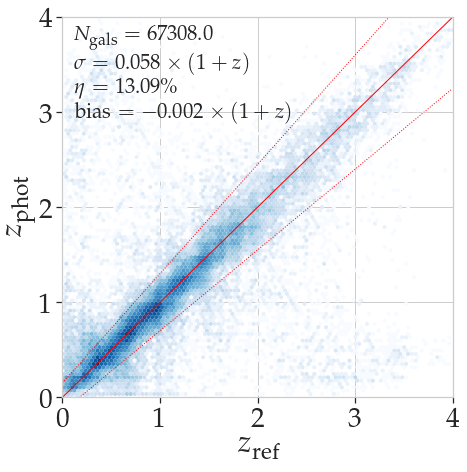

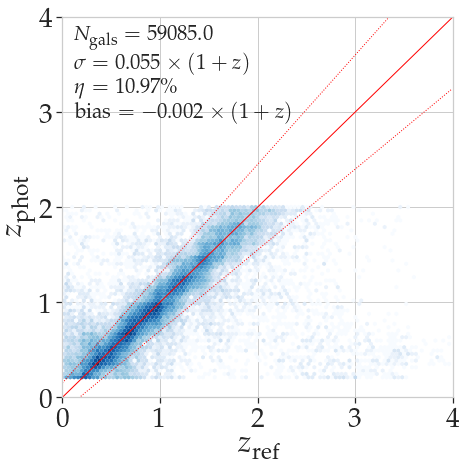

In [39]:
reload(photoz_metrics)

SELECT="(vis_obs_mag < 24.5) & (vis_obs_mag_err > 0.0)"
# SELECT="(vis_obs_mag < 22.5) & (vis_obs_mag_err > 0.0)"


# file_input = '{}/{}/pz_r.fits'.format(DATADIR, RESULTDIR)
file_input = '{}/fluxes_COSMOS15_West_test_vis24.5_pz_r.fits'.format(DATADIR)

print(file_input)

data_fix = photoz_metrics.read_data(
    file_input, select=SELECT, 
    input_type = 'ECLD_PHZ', 
    check_norm=False, 
    normalise=False,
    reject_outliers=False,
    )



# side-by-side version
if False:
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))
    photoz_metrics.plot_scatter(
        data_fix['z_ref'], data_fix['z'], 
        0.0, 4.0, ax=ax1, density=False)
    photoz_metrics.plot_scatter(
        data_fix['z_ref'], data_fix['z'], 
        0.0, 4.0, ax=ax2, density=True)

    f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))
    s = (0.2 < data_fix['z']) & (data_fix['z'] < 2.0)
    photoz_metrics.plot_scatter(
        data_fix['z_ref'][s], data_fix['z'][s], 
        0.0, 4.0, ax=ax1, density=False)
    photoz_metrics.plot_scatter(
        data_fix['z_ref'][s], data_fix['z'][s], 
        0.0, 4.0, ax=ax2, density=True)

# only density
f, (ax2) = plt.subplots(1,1, figsize=(7,7))
#photoz_metrics.plot_scatter(
#    data_fix['z_ref'], data_fix['z'], 
#    0.0, 4.0, ax=ax1, density=False)
photoz_metrics.plot_scatter(
    data_fix['z_ref'], data_fix['z'], 
    0.0, 4.0, ax=ax2, density=True)

f.savefig('../plots/zp_zref_fixed_all.pdf')

f, (ax2) = plt.subplots(1,1, figsize=(7,7))
s = (0.2 < data_fix['z']) & (data_fix['z'] < 2.0)
#photoz_metrics.plot_scatter(
#    data_fix['z_ref'][s], data_fix['z'][s], 
#    0.0, 4.0, ax=ax1, density=False)
photoz_metrics.plot_scatter(
    data_fix['z_ref'][s], data_fix['z'][s], 
    0.0, 4.0, ax=ax2, density=True)

f.savefig('../plots/zp_zref_fixed_0_2_2_0.pdf')



Reading /Users/coupon/data/euclid/varTrans/fluxes_COSMOS15_West_test_vis24.5_pz_r.fits...Done
Applying selection: (data['vis_obs_mag'] < 24.5) & (data['vis_obs_mag_err'] > 0.0)
Renormalising PDFs...Done
Rejecting potential outliers...Done (rejected 8615/67396 PDFs (12.782657724494035%).


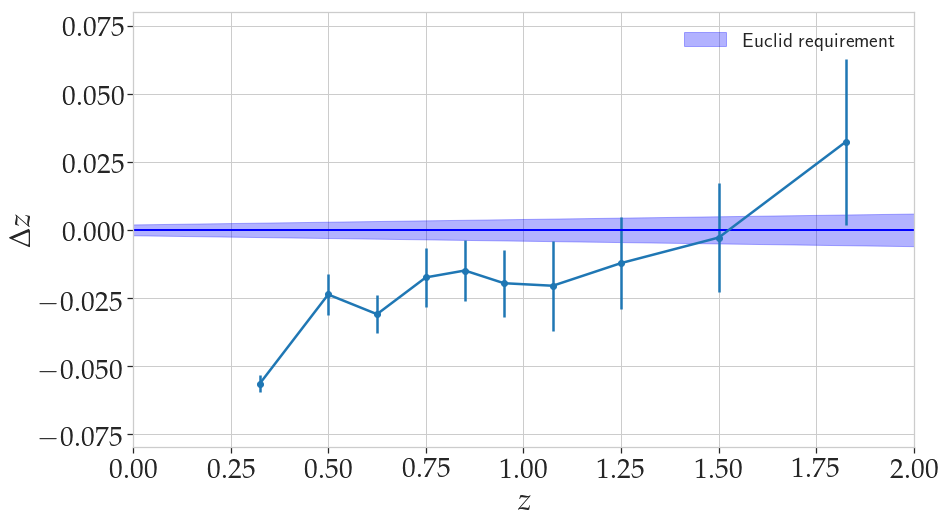

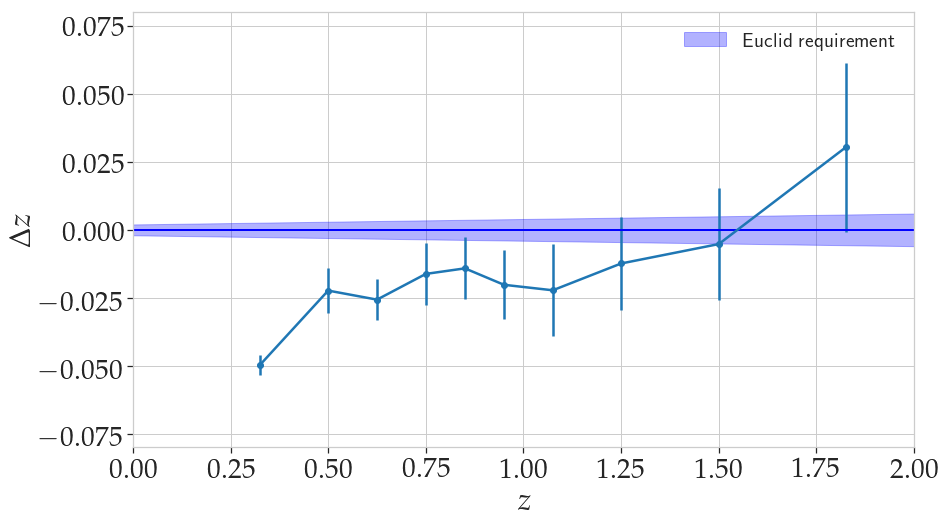

In [40]:
# bias
f, (ax2) = plt.subplots(1,1)
photoz_metrics.plot_bias(
    data_fix['z_ref'], 
    data_fix['z'], 
    data_fix['PDF'], 
    data_fix['PDF_bins'], ax=ax2)

f.savefig('../plots/mean_z_fixed_all.pdf')

data_fix_no_outliers = photoz_metrics.read_data(
    file_input, select=SELECT, 
    input_type = 'ECLD_PHZ', 
    check_norm=False, 
    normalise=True,
    reject_outliers=True,
    )


f, (ax2) = plt.subplots(1,1)
photoz_metrics.plot_bias(
    data_fix_no_outliers['z_ref'], 
    data_fix_no_outliers['z'], 
    data_fix_no_outliers['PDF'], 
    data_fix_no_outliers['PDF_bins'], ax=ax2)

f.savefig('../plots/mean_z_fixed_all_no_outliers.pdf')

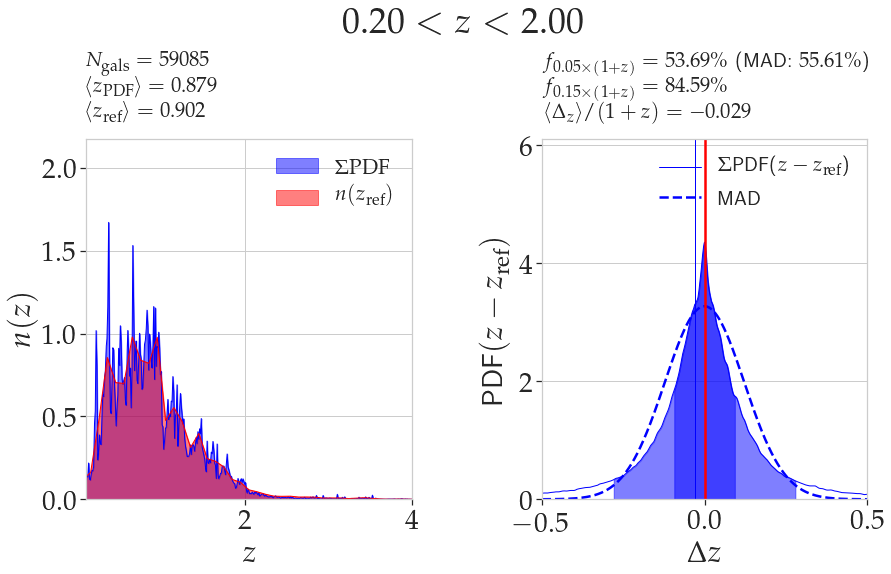

In [41]:
# reload(photoz_metrics)

# plot PDF stats
photoz_metrics.plot_PDF(
        data_fix['z_ref'], data_fix['z'], data_fix['PDF'],
        data_fix['PDF_bins'], z_bins=[0.2,2.0], 
        file_output='../plots/PDF_metric.pdf')



### Variable

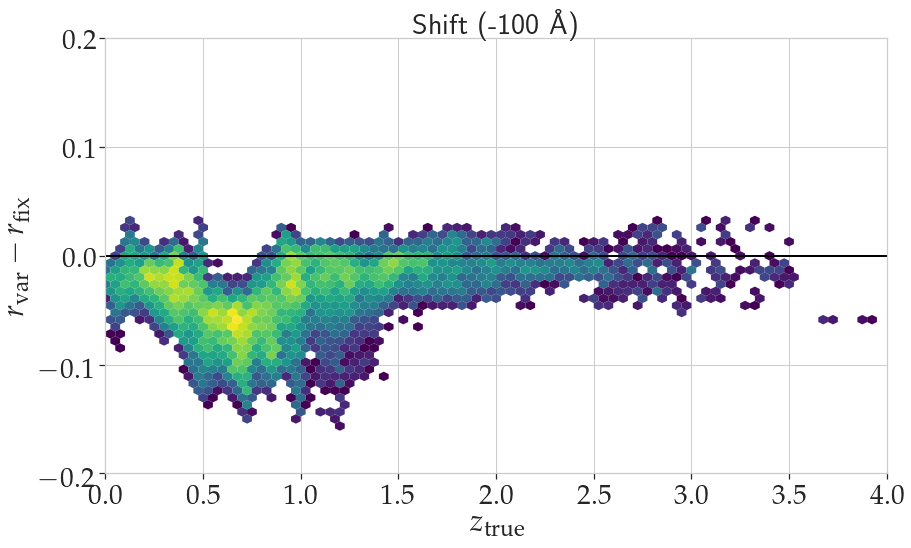

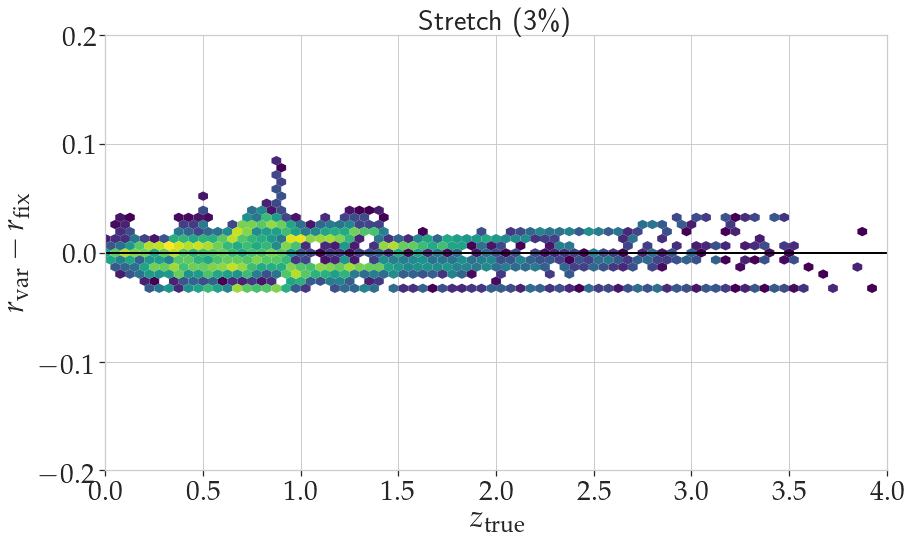

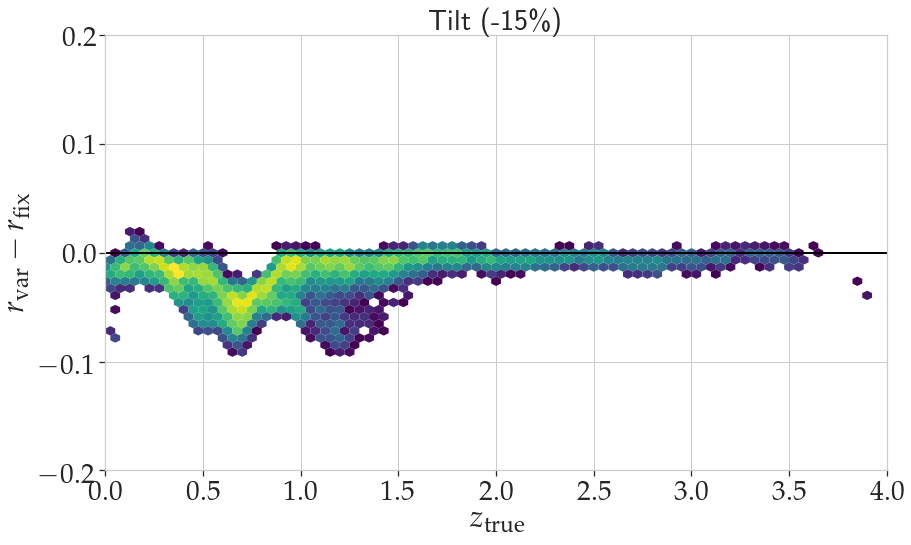

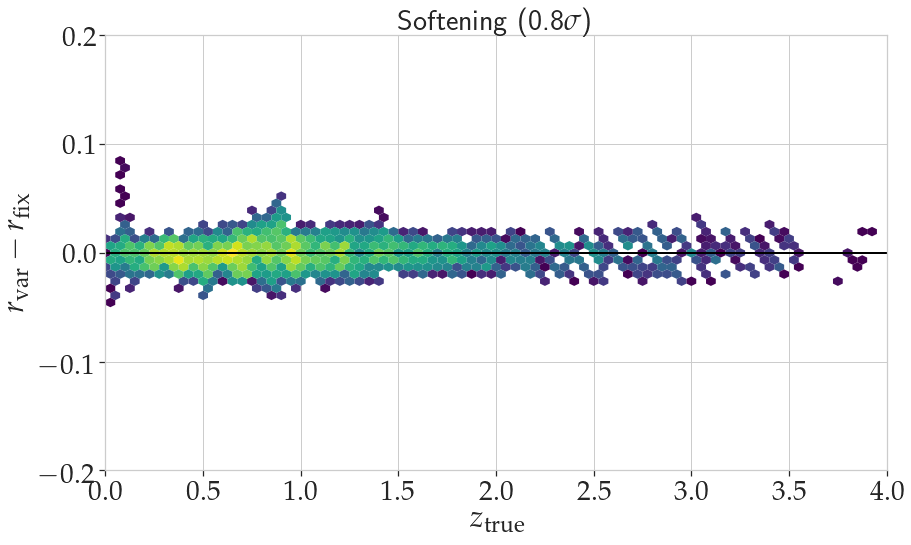

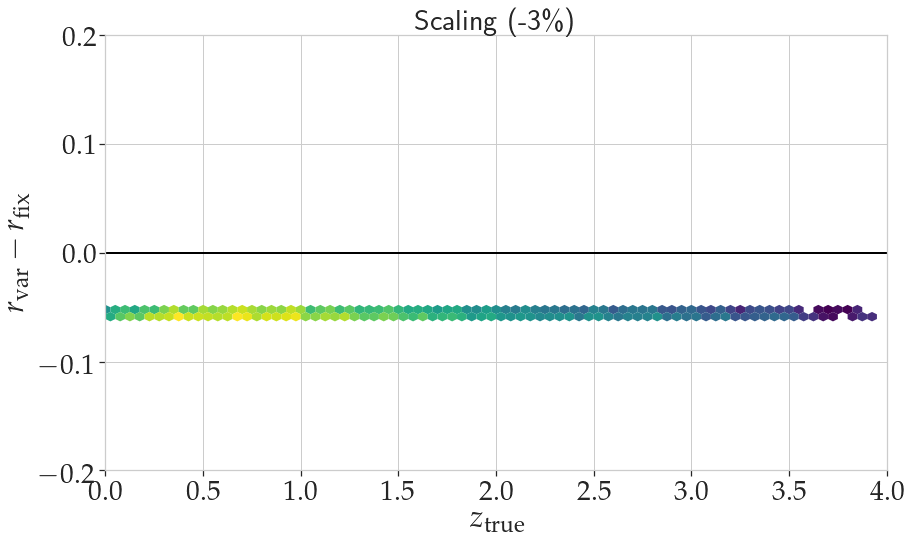

In [42]:
# plot mag differences

# import photometry catalogue and select shear sample
with fits.open(DATADIR+'/fluxes_COSMOS15_West_test_vis24.5.fits') as data:
     fluxes = data[1].data

zmin, zmax = 0.0, 4.0
maxDiff = 0.2

name = {'shift0': 'Shift (-100~\AA{})',
       'stretch9': 'Stretch (3\%)',
       'tilt0' : 'Tilt (-15\%)',
       'softening9' : 'Softening (0.8$\sigma$)',
       'scaling0' : 'Scaling (-3\%)'
       }

for var in ['shift0', 'stretch9', 'tilt0', 'softening9', 'scaling0'] :
    
    # diff = fluxes['r_obs_mag']-fluxes['r_'+var+'_obs_mag']
    diff = 2.5*np.log10(fluxes['r_'+var]/fluxes['r'])

    s = (fluxes['vis_obs_mag']<24.5) \
        & (fluxes['vis_obs_mag_err']<0.1) \
        & (abs(diff) < maxDiff) & (abs(diff) > 1.e-6) \
        & (zmin < fluxes['z_true']) & (fluxes['z_true'] < zmax)
    
    # bins='log',
    
    fig, ax = plt.subplots()
    hb = ax.hexbin(
        fluxes['z_true'][s], diff[s],
        gridsize=80, cmap='viridis', 
        mincnt=5, bins='log', 
        edgecolors=None, extent=(0.0, 4.0, -0.3,0.3))
    ax.axis([zmin, zmax, -maxDiff, +maxDiff])
    ax.plot([zmin, zmax], [0.0, 0.0], lw=2, c='black')

    ax.set_title(name[var])
    ax.set_xlabel(r'$z_\mathrm{true}$')
    ax.set_ylabel(r'$r_\mathrm{var}-r_\mathrm{fix}$')

    
    fig.savefig('../plots/mag_diff_{}.pdf'.format(var))

Reading /Users/coupon/data/euclid/varTrans/fluxes_COSMOS15_West_test_vis24.5_pz_r_shift0.fits...Done
Applying selection: (data['vis_obs_mag'] < 24.5) & (data['vis_obs_mag_err'] > 0.0)


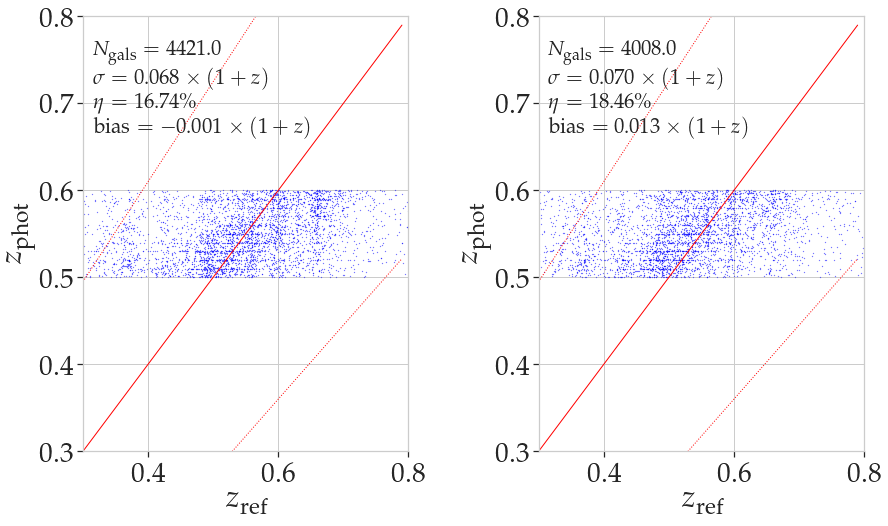

In [43]:
SELECT="(vis_obs_mag < 24.5) & (vis_obs_mag_err > 0.0)"

file_input = '{}/fluxes_COSMOS15_West_test_vis24.5_pz_r_shift0.fits'.format(DATADIR)
data_var = photoz_metrics.read_data(
    file_input, select=SELECT, 
    input_type = 'ECLD_PHZ', 
    check_norm=False)

fig, ax = plt.subplots(1,2)

s = (0.5 < data_fix['z']) & (data_fix['z'] < 0.6)
photoz_metrics.plot_scatter(
    data_fix['z_ref'][s], data_fix['z'][s], 
    0.3, 0.8, ax=ax[0], density=False)

s = (0.5 < data_var['z']) & (data_var['z'] < 0.6)
photoz_metrics.plot_scatter(
    data_var['z_ref'][s], data_var['z'][s], 
    0.3, 0.8, ax=ax[1], density=False)

fig.subplots_adjust(wspace=0.4)
fig.savefig('../plots/zp_zref_zoom.pdf')

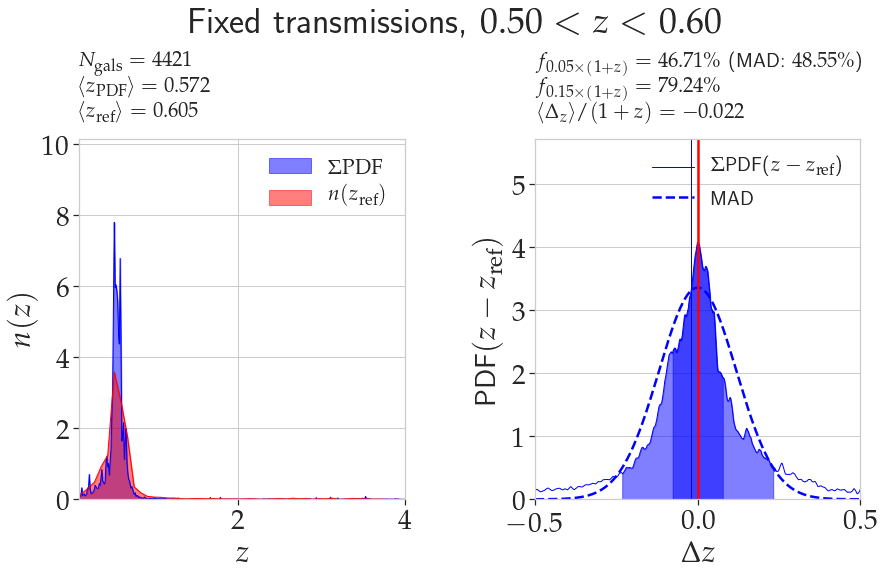

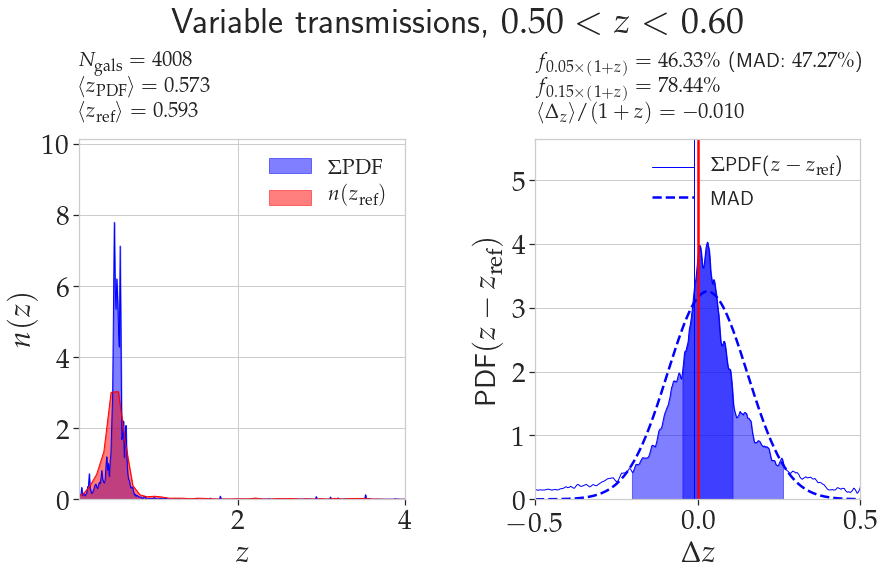

In [44]:
# reload(photoz_metrics)

# plot PDF stats - fixed transmissions
photoz_metrics.plot_PDF(
        data_fix['z_ref'], data_fix['z'], data_fix['PDF'], 
        data_fix['PDF_bins'], z_bins=[0.5,0.6], 
        title='Fixed transmissions, ', 
        file_output='../plots/PDF_metric_example_fixed.pdf',
    )

# plot PDF stats - variable transmissions
photoz_metrics.plot_PDF(
        data_var['z_ref'], data_var['z'], data_var['PDF'], 
        data_var['PDF_bins'], z_bins=[0.5,0.6], 
        title='Variable transmissions, ',
        file_output='../plots/PDF_metric_example_var.pdf',
)

In [51]:
def plot_delta_z_redshift(
        var_name, var_values, var_units,
        result_file='fluxes_COSMOS15_West_test_vis24.5'):
    """ Plot delta z = <z_var> - <z_fix> """
    
    dz_mean_fix = 0.0
    for i in range(N_SAMPLES):
        data_fix = pd.read_csv(DATADIR+'/'+result_file+'/'+str(i)+'_pz_r_PDF_tomo.csv')
        dz_mean_fix += (data_fix['zmean']-data_fix['zmean_ref'])
    dz_mean_fix /= N_SAMPLES

    bins_center = (data_fix['zmin']+data_fix['zmax'])/2.0

    N_var = len(var_values)
            
    # initialise figure
    fig, ax = plt.subplots()

    ax.set_title(var_name.title())

    ax.set_ylim((-0.03,0.03))
    ax.set_xlim((0.0,2.0))
    
    ax.plot([0.0,2.0],[0.0,0.0], c='blue', lw=2)
    
    ax.fill_between(
        [0.0,2.0], [-0.002*(1.0+0.0),-0.002*(1.0+2.0)], 
        [+0.002*(1.0+0.0),+0.002*(1.0+2.0)], 
        color='blue', alpha=0.3, label='Euclid requirement')
    
    ax.set_xlabel(r'$z$')
    ax.set_ylabel(r'$\Delta z_\mathrm{var}$')
            
    fac = 1.0
    if var_name == 'stretch' or var_name == 'tilt' or var_name == 'scaling':
        fac = 100.0
    
    # plot two extremes and middle one
    for n in [0, 5, 9]:
        # dz_mean_var = 0.0
        result = np.zeros((N_SAMPLES, N_var))
        for i in range(N_SAMPLES):
            data_var = pd.read_csv(DATADIR+'/'+result_file+'/'+str(i)+'_pz_r_'+var_name+str(n)+'_PDF_tomo.csv')
            result[i, :] = (data_var['zmean']-data_var['zmean_ref']) - dz_mean_fix
        
        dz_mean_var = np.mean(result, axis=0)
        dz_mean_var_err = np.sqrt(2.)*np.std(result, axis=0)/np.sqrt(N_SAMPLES)

        ax.errorbar(
            bins_center, dz_mean_var, yerr=dz_mean_var_err, label=r'{0:+.1f}{1}'.format(
                var_values[n]*fac, var_units), marker='o') 
    ax.legend(fontsize='x-small')
    
    fig.savefig('../plots/delta_z_redshift_'+var_name+'.pdf')
     
    return

RuntimeError: latex was not able to process the following string:
b'+0.0\\\\sigma'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/coupon/.matplotlib/tex.cache/6b37125dc50ba04319871a7144999cf8.tex
LaTeX2e <2017-04-15>
Babel <3.10> and hyphenation patterns for 84 language(s) loaded.
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2017/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2017/texmf-dist/tex/latex/psnfss/mathpazo.sty)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2017/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./6b37125dc50ba04319871a7144999cf8.aux)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1cmr.fd)
(/usr/local/texlive/2017/texmf-dist/tex/latex/psnfss/ot1ppl.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.13 ...20.820000}{26.025000}{\sffamily +0.0\sigma
                                                  }
No pages of output.
Transcript written on 6b37125dc50ba04319871a7144999cf8.log.




Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x131e6090d0> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'+0.0\\\\sigma'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/coupon/.matplotlib/tex.cache/6b37125dc50ba04319871a7144999cf8.tex
LaTeX2e <2017-04-15>
Babel <3.10> and hyphenation patterns for 84 language(s) loaded.
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2017/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2017/texmf-dist/tex/latex/psnfss/mathpazo.sty)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2017/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./6b37125dc50ba04319871a7144999cf8.aux)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1cmr.fd)
(/usr/local/texlive/2017/texmf-dist/tex/latex/psnfss/ot1ppl.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.13 ...20.820000}{26.025000}{\sffamily +0.0\sigma
                                                  }
No pages of output.
Transcript written on 6b37125dc50ba04319871a7144999cf8.log.




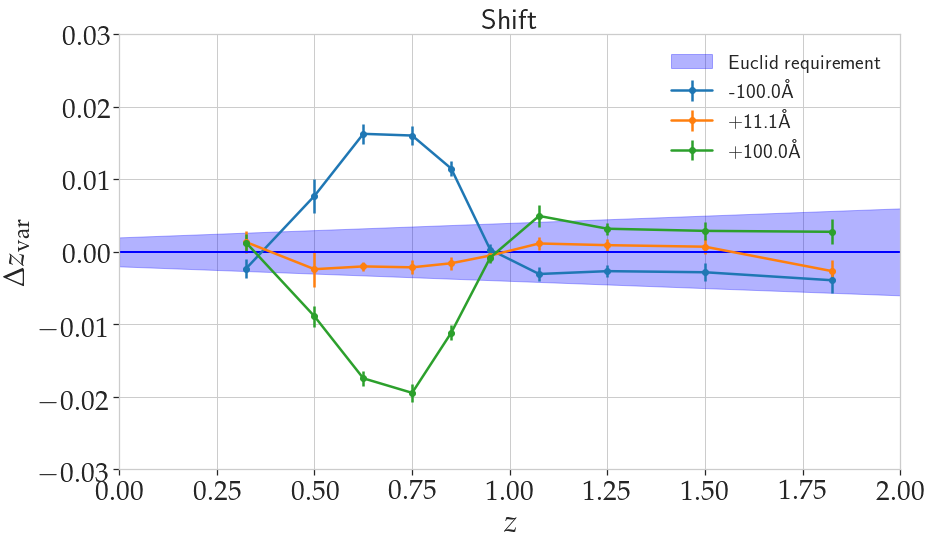

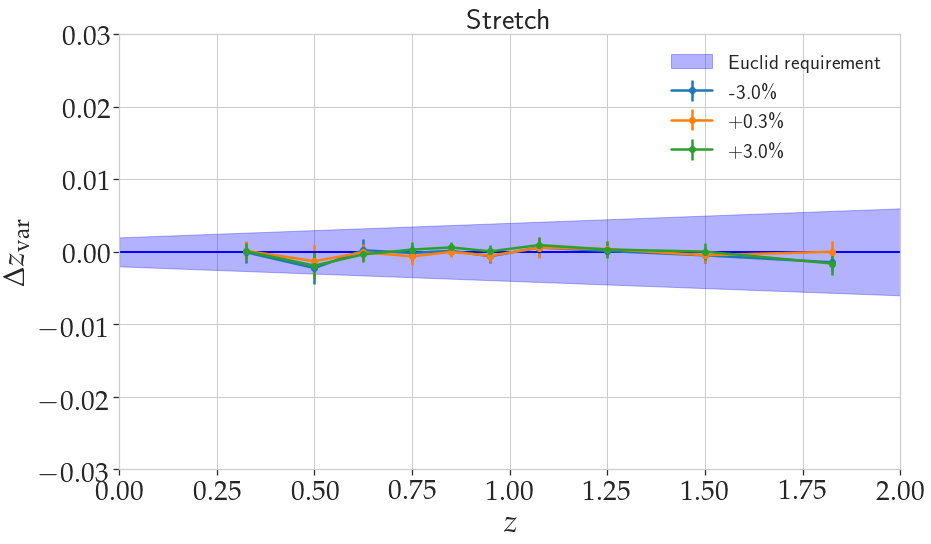

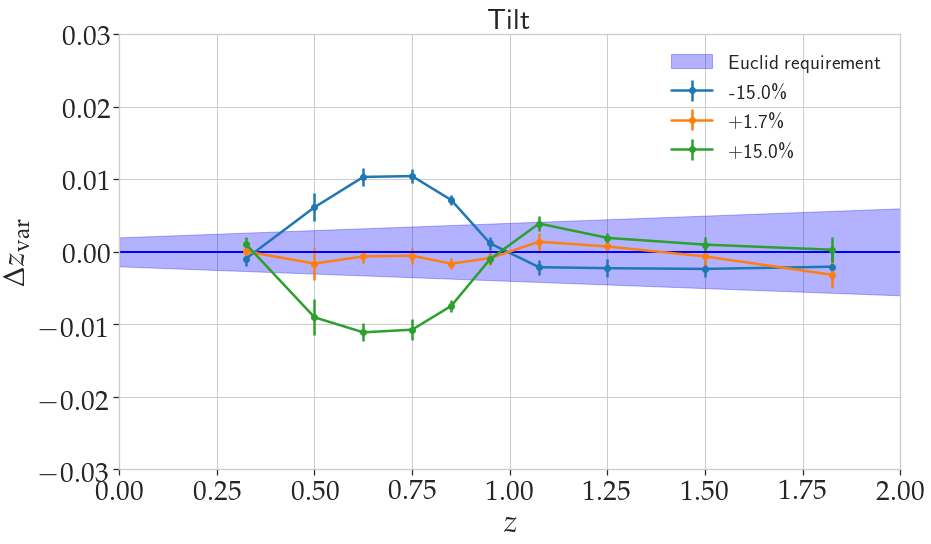

RuntimeError: latex was not able to process the following string:
b'+0.0\\\\sigma'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/coupon/.matplotlib/tex.cache/6b37125dc50ba04319871a7144999cf8.tex
LaTeX2e <2017-04-15>
Babel <3.10> and hyphenation patterns for 84 language(s) loaded.
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2017/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2017/texmf-dist/tex/latex/psnfss/mathpazo.sty)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2017/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./6b37125dc50ba04319871a7144999cf8.aux)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1cmr.fd)
(/usr/local/texlive/2017/texmf-dist/tex/latex/psnfss/ot1ppl.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.13 ...20.820000}{26.025000}{\sffamily +0.0\sigma
                                                  }
No pages of output.
Transcript written on 6b37125dc50ba04319871a7144999cf8.log.




<Figure size 1008x576 with 1 Axes>

In [52]:
# if Latex error, rerun
for var_name in ['shift', 'stretch', 'tilt', 'softening', 'scaling']:
    plot_delta_z_redshift(var_name, VAR_VALUES[var_name],VAR_UNITS[var_name])

In [49]:
def plot_delta_z_var(
        var_name, var_values, var_units,
        result_file='fluxes_COSMOS15_West_test_vis24.5'):
    """ Plot delta z = <z_var> - <z_fix> """
    
    # fixed transmission (reference)
    dz_mean_fix = 0.0
    for i in range(N_SAMPLES):
        data_fix = pd.read_csv(DATADIR+'/'+result_file+'/'+str(i)+'_pz_r_PDF_z0.63.csv')
        dz_mean_fix += (data_fix['zmean']-data_fix['zmean_ref'])
    dz_mean_fix /= N_SAMPLES
    
    bins_center = (data_fix['zmin']+data_fix['zmax'])/2.0

    one_plus_z = 1.0+bins_center[0]
    
    fac = 1.0
    if var_name == 'stretch' or var_name == 'tilt' or var_name == 'scaling':
        fac = 100.0

    # initialise figure
    fig, ax = plt.subplots(1,1)
    
    ax.set_title(var_name.title()+' ($z\sim0.63$)')
    ax.set_ylim((-0.03,0.03))
    xlim = ax.set_xlim((var_values[0]*fac,var_values[-1]*fac))
    ax.set_xlabel('{0} [{1}]'.format(var_name,var_units))
    ax.set_ylabel(r'$\Delta z_\mathrm{var}$')
    ax.plot(xlim,[0.0,0.0], c='blue', lw=2)

    ax.fill_between(
        xlim, [-0.002*one_plus_z,-0.002*one_plus_z], 
        [+0.002*one_plus_z,+0.002*one_plus_z], 
        color='blue', alpha=0.3, label='Euclid requirement')
     
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))   
        
    Deltaz = []
    Deltaz_err = []

    for n in range(len(var_values)):

        result = np.zeros(N_SAMPLES)
        for i in range(N_SAMPLES):
            data_var = pd.read_csv(
                DATADIR+'/'+result_file+'/'+str(i)
                +'_pz_r_'+var_name+str(n)+'_PDF_z0.63.csv')
            result[i] = (data_var['zmean']-data_var['zmean_ref']) - dz_mean_fix

        # N = data_var['N']
        dz_mean_var = np.mean(result, axis=0)
        dz_mean_var_err = np.std(result, axis=0)

        Deltaz.append(dz_mean_var)
        Deltaz_err.append(dz_mean_var_err/np.sqrt(N_SAMPLES))
    
    ax.errorbar(var_values*fac, Deltaz, yerr=Deltaz_err, marker='o', label='Measured')

    if var_name == 'shift':
        ax.plot(var_values, -var_values/4000.0/(1.5), label='Naive model')
    
    ax.legend(fontsize='x-small', loc='upper right')

    fig.set_tight_layout(True)

    fig.savefig('../plots/delta_z_var_'+var_name+'.pdf')

    
    return Deltaz, Deltaz_err

RuntimeError: latex was not able to process the following string:
b'softening [\\\\sigma]'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/coupon/.matplotlib/tex.cache/b22723b8172a811eebeb52c09441ba07.tex
LaTeX2e <2017-04-15>
Babel <3.10> and hyphenation patterns for 84 language(s) loaded.
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2017/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2017/texmf-dist/tex/latex/psnfss/mathpazo.sty)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2017/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file b22723b8172a811eebeb52c09441ba07.aux.
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1cmr.fd)
(/usr/local/texlive/2017/texmf-dist/tex/latex/psnfss/ot1ppl.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.13 ...00}{37.500000}{\sffamily softening [\sigma
                                                  ]}
No pages of output.
Transcript written on b22723b8172a811eebeb52c09441ba07.log.




Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x131e6090d0> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'softening [\\\\sigma]'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/coupon/.matplotlib/tex.cache/b22723b8172a811eebeb52c09441ba07.tex
LaTeX2e <2017-04-15>
Babel <3.10> and hyphenation patterns for 84 language(s) loaded.
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2017/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2017/texmf-dist/tex/latex/psnfss/mathpazo.sty)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2017/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./b22723b8172a811eebeb52c09441ba07.aux)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1cmr.fd)
(/usr/local/texlive/2017/texmf-dist/tex/latex/psnfss/ot1ppl.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.13 ...00}{37.500000}{\sffamily softening [\sigma
                                                  ]}
No pages of output.
Transcript written on b22723b8172a811eebeb52c09441ba07.log.




/Users/coupon/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


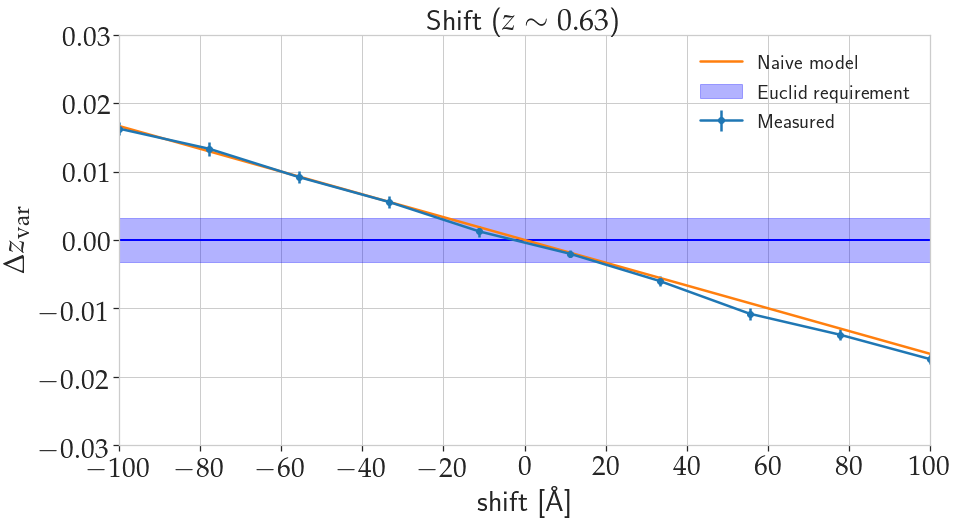

/Users/coupon/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


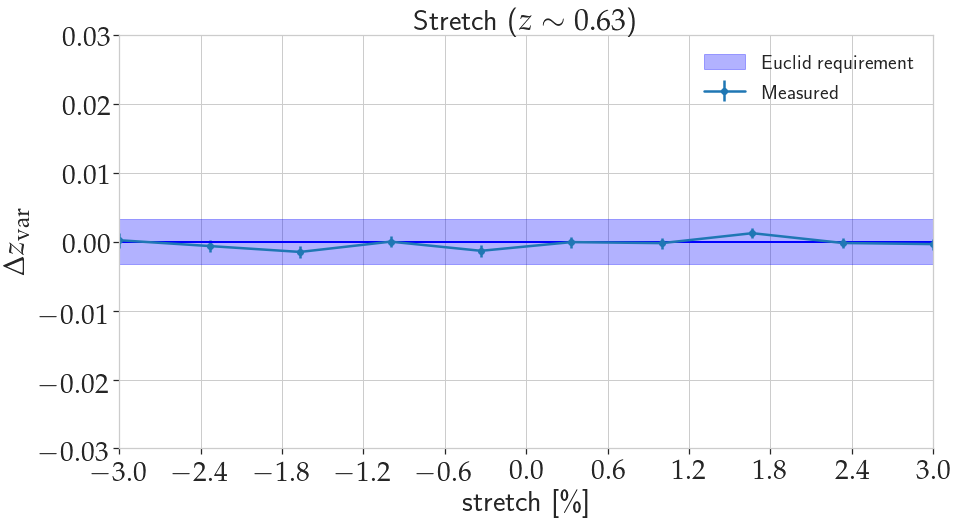

/Users/coupon/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


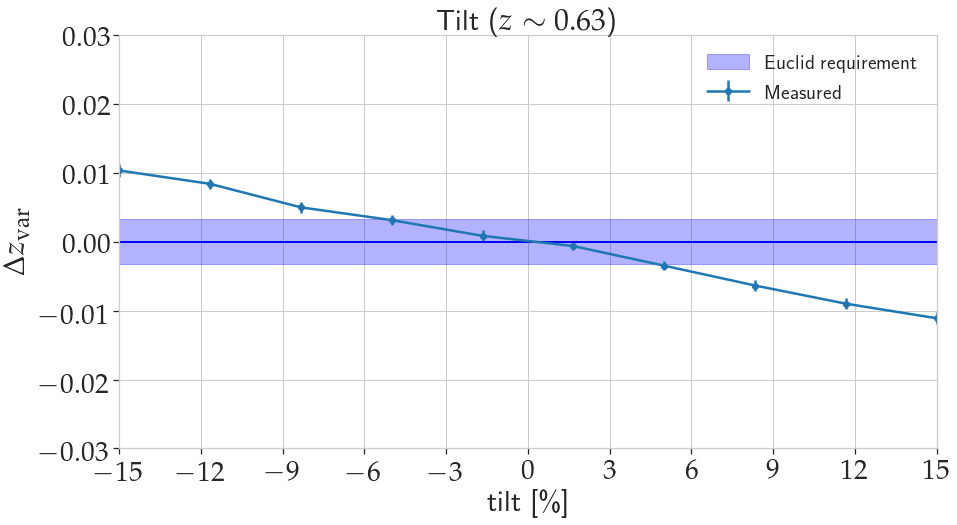

RuntimeError: latex was not able to process the following string:
b'softening [\\\\sigma]'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/coupon/.matplotlib/tex.cache/b22723b8172a811eebeb52c09441ba07.tex
LaTeX2e <2017-04-15>
Babel <3.10> and hyphenation patterns for 84 language(s) loaded.
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2017/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2017/texmf-dist/tex/latex/psnfss/mathpazo.sty)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2017/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./b22723b8172a811eebeb52c09441ba07.aux)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1cmr.fd)
(/usr/local/texlive/2017/texmf-dist/tex/latex/psnfss/ot1ppl.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.13 ...00}{37.500000}{\sffamily softening [\sigma
                                                  ]}
No pages of output.
Transcript written on b22723b8172a811eebeb52c09441ba07.log.




<Figure size 1008x576 with 1 Axes>

In [50]:
#for var_name in ['shift', 'widening', 'skewing', 'softening']:
#    plot_delta_z_var(var_name, var_values[var_name])

df_list = []
for var_name in ['shift', 'stretch', 'tilt', 'softening', 'scaling']:
    df = pd.read_csv('../results/trans_stats_{}.csv'.format(var_name))
    df['Deltaz'], df['Deltaz_err'] = plot_delta_z_var(
            var_name, VAR_VALUES[var_name], VAR_UNITS[var_name])
    df['var_name'] = [var_name]*10
    df_list.append(df)

# merge first moments and chi2
pd.concat(df_list).to_csv('../results/trans_stats_Deltaz.csv', index=False)